<a href="https://colab.research.google.com/github/J0KERmin/Tutorial/blob/main/Lab3_Python_for_data_science.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Мета лабораторної роботи полягає в розробці моделі класифікації, яка здатна визначити клас магазину (Small, Medium, High) на основі різних факторів.

В першу чергу імпортуємо необхідні бібліотеки:

In [69]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

Додаємо наш датасет:

In [70]:
import gdown
import pandas as pd

url = 'https://drive.google.com/uc?id=1AWIMDRHlQHqMObznZ751tpLBP8Y05zzo'
output = '/content/BigMart_Sales_Data.csv'
gdown.download(url, output, quiet=False)

df = pd.read_csv(output)

df.head()

Downloading...
From: https://drive.google.com/uc?id=1AWIMDRHlQHqMObznZ751tpLBP8Y05zzo
To: /content/BigMart_Sales_Data.csv
100%|██████████| 526k/526k [00:00<00:00, 5.36MB/s]


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.300,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,NaN,Tier 2,Supermarket Type1
4,FDY38,NaN,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3


Переглянемо коротку довідку про датасет:

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5681 entries, 0 to 5680
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            5681 non-null   object 
 1   Item_Weight                4705 non-null   float64
 2   Item_Fat_Content           5681 non-null   object 
 3   Item_Visibility            5681 non-null   float64
 4   Item_Type                  5681 non-null   object 
 5   Item_MRP                   5681 non-null   float64
 6   Outlet_Identifier          5681 non-null   object 
 7   Outlet_Establishment_Year  5681 non-null   int64  
 8   Outlet_Size                4075 non-null   object 
 9   Outlet_Location_Type       5681 non-null   object 
 10  Outlet_Type                5681 non-null   object 
dtypes: float64(3), int64(1), object(7)
memory usage: 488.3+ KB


Датасет має: 5681 рядок, 11 колонок, 3 бульові значення, 1 int64 і 7 об'єктів.

Короткий опис назв стовпців:
1. Item_Identifier - Ідентифікатор_товару
2. Item_Weight - Вага_товару
3. Item_Fat_Content - Вміст_жиру_товару
4. Item_Visibility - Видимість_товару
5. Item_Type - Тип_товару
6. Item_MRP - Максимальна_роздрібна_ціна_товару
7. Outlet_Identifier - Ідентифікатор_магазину
8. Outlet_Establishment_Year - Рік_заснування_магазину
9. Outlet_Size - Розмір_магазину
10. Outlet_Location_Type - Тип_розташування_магазину
11. Outlet_Type - Тип_магазину

Для зручності перейменуємо назви стовпців в датасеті

In [72]:
df.rename(columns={'Item_Identifier': 'item_identifier',
                   'Item_Weight':'item_weight',
                   'Item_Fat_Content':'item_fat_content',
                   'Item_Visibility':'item_visibility',
                   'Item_Type':'item_type',
                   'Item_MRP':'item_mrp',
                   'Outlet_Identifier':'outlet_identifier',
                   'Outlet_Establishment_Year':'outlet_establishment_year',
                   'Outlet_Size':'outlet_size',
                   'Outlet_Location_Type':'outlet_location_type',
                   'Outlet_Type':'outlet_type'},inplace=True)


In [73]:
df.head()


,item_identifier,item_weight,item_fat_content,item_visibility,item_type,item_mrp,outlet_identifier,outlet_establishment_year,outlet_size,outlet_location_type,outlet_type
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.300,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,NaN,Tier 2,Supermarket Type1
4,FDY38,NaN,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3


Перевіримо, чи є в датасеті NaN елементи (пропуски в даних):

In [74]:
df.isnull().sum()

item_identifier                 0
item_weight                   976
item_fat_content                0
item_visibility                 0
item_type                       0
item_mrp                        0
outlet_identifier               0
outlet_establishment_year       0
outlet_size                  1606
outlet_location_type            0
outlet_type                     0
dtype: int64

В даному датасеті є чимало NaN елементів, які варто видалити або заповнити.

Видалимо рядки, в яких є хоча б один NaN елемент:

In [75]:
df = df.dropna()

Перевіримо, чи є в датасеті залишились NaN елементи (пропуски в даних):

In [76]:
df.isnull().sum()

item_identifier              0
item_weight                  0
item_fat_content             0
item_visibility              0
item_type                    0
item_mrp                     0
outlet_identifier            0
outlet_establishment_year    0
outlet_size                  0
outlet_location_type         0
outlet_type                  0
dtype: int64

В датасеті було успішно видалені NaN елементи.

**Розвідувальний аналіз даних**

In [77]:
df.describe()

,item_weight,item_visibility,item_mrp,outlet_establishment_year
count,3099.000000,3099.000000,3099.000000,3099.000000
mean,12.658206,0.059063,140.036189,1999.189739
std,4.616934,0.043592,61.608135,7.387906
min,4.555000,0.000000,31.990000,1987.000000
25%,8.675000,0.025824,93.310700,1997.000000
50%,12.350000,0.049154,141.315400,1999.000000
75%,16.600000,0.085354,184.993700,2004.000000
max,21.350000,0.185913,266.588400,2009.000000


Будуємо коробчасту діаграму для показника "item_mrp":

<Axes: >

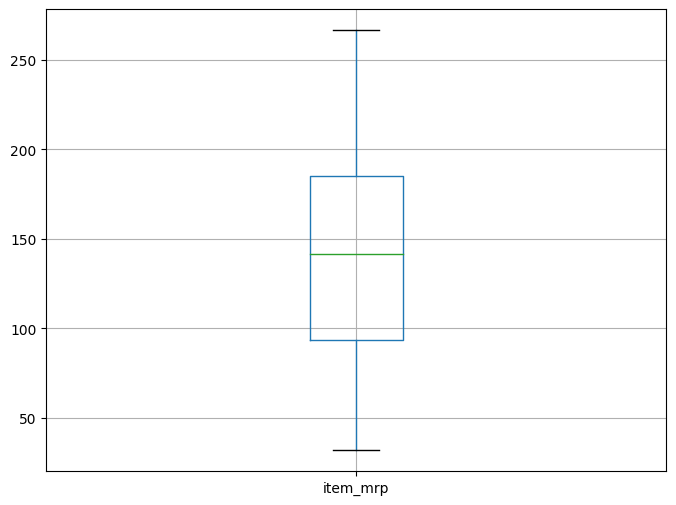

In [78]:
df[['item_mrp']].boxplot(figsize=(8,6))

Я обрала не видаляти данні, так як не бачу сильних викидів в датасеті.

Будуємо коробчасту діаграму для показника "item_visibility":

<Axes: >

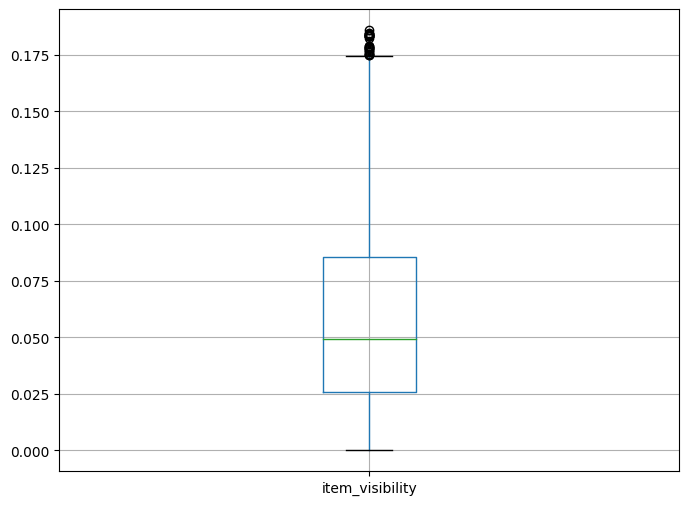

In [79]:
df[['item_visibility']].boxplot(figsize=(8,6))

Видаляю інформацію про коеф. видимості товару, який вище за 0.175(значення найбільше відрізняються від інших):

In [80]:
df.drop(df[df['item_visibility'] > 0.175].index, inplace=True)

Будуємо коробчасту діаграму для показника "item_weight":

<Axes: >

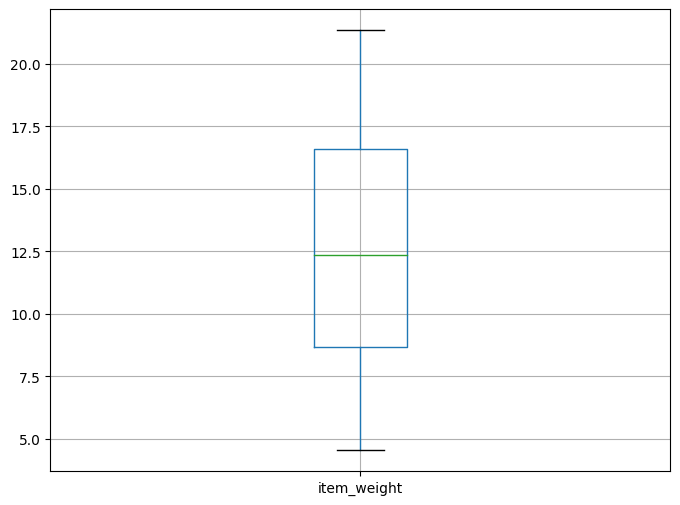

In [81]:
df[['item_weight']].boxplot(figsize=(8,6))

Я обрала не видаляти данні, так як не бачу сильних викидів в датасеті.

Будуємо коробчасту діаграму для показника "outlet_establishment_year":

<Axes: >

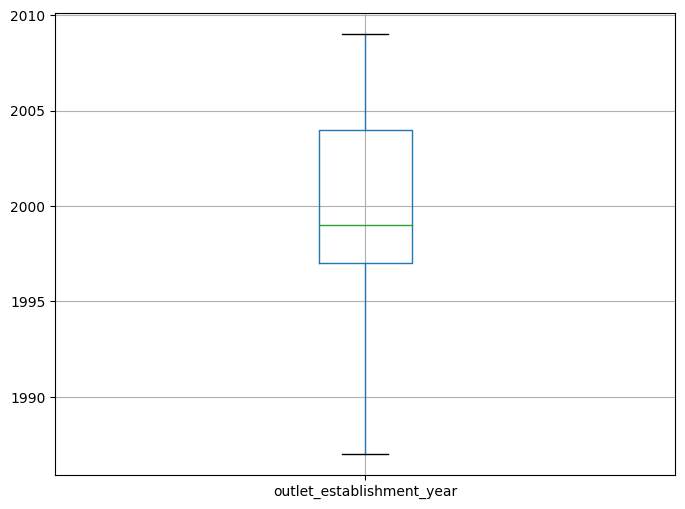

In [82]:
df[['outlet_establishment_year']].boxplot(figsize=(8,6))

Видаляю інформацію про рік створення компанії, які засновані до 1990 (значення найбільше відрізняються від інших)

In [83]:
df.drop(df[df['outlet_establishment_year'] < 1990].index, inplace=True)

Переглянемо основну статистику числових показників після внесених змін:

In [84]:
df.describe()

,item_weight,item_visibility,item_mrp,outlet_establishment_year
count,2461.000000,2461.000000,2461.000000,2461.000000
mean,12.700000,0.057822,139.759250,2002.234864
std,4.616615,0.042525,61.755118,4.656504
min,4.555000,0.000000,32.390000,1997.000000
25%,8.710000,0.025581,92.580400,1997.000000
50%,12.500000,0.048107,141.015400,1999.000000
75%,16.700000,0.083854,185.160800,2004.000000
max,21.350000,0.174758,266.588400,2009.000000


Перекодуємо дані в стовпці "outlet_location_type" та "item_fat_content" в числові:

In [85]:
df.outlet_location_type = df.outlet_location_type.replace ({'Tier 1': 1,
                                                            'Tier 2': 2,
                                                            'Tier 3': 3})
df['item_fat_content'].replace({'reg': 'Regular', 'LF': 'Low Fat', 'low fat': 'Low Fat'}, inplace=True)
df.item_fat_content = df.item_fat_content.replace({'Regular': '1', 'Low Fat': '0'})
df.outlet_type = df.outlet_type.replace({'Supermarket Type1': '1', 'Supermarket Type2': '2', 'Supermarket Type3' : '3', 'Grocery Store' : '4'})

Після змін датасет має такий вигляд (перші 5 записів):

In [86]:
df.head()

,item_identifier,item_weight,item_fat_content,item_visibility,item_type,item_mrp,outlet_identifier,outlet_establishment_year,outlet_size,outlet_location_type,outlet_type
0,FDW58,20.750,0,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,1,1
5,FDH56,9.800,1,0.063817,Fruits and Vegetables,117.1492,OUT046,1997,Small,1,1
6,FDL48,19.350,1,0.082602,Baking Goods,50.1034,OUT018,2009,Medium,3,2
13,FDU11,4.785,0,0.092738,Breads,122.3098,OUT049,1999,Medium,1,1
15,FDM24,6.135,1,0.079451,Baking Goods,151.6366,OUT049,1999,Medium,1,1


In [87]:
df.dtypes

item_identifier               object
item_weight                  float64
item_fat_content              object
item_visibility              float64
item_type                     object
item_mrp                     float64
outlet_identifier             object
outlet_establishment_year      int64
outlet_size                   object
outlet_location_type           int64
outlet_type                   object
dtype: object

Змінимо тип даних в стовпцях, які ми щойно змінювали:

In [88]:
df.outlet_location_type = df.outlet_location_type.astype(int)
df.item_fat_content = df.item_fat_content.astype(int)
# df.outlet_size = df.outlet_size.astype(int)
df.outlet_type = df.outlet_type.astype(int)
df.dtypes

item_identifier               object
item_weight                  float64
item_fat_content               int64
item_visibility              float64
item_type                     object
item_mrp                     float64
outlet_identifier             object
outlet_establishment_year      int64
outlet_size                   object
outlet_location_type           int64
outlet_type                    int64
dtype: object

In [89]:
object_columns = df.select_dtypes(include=['object']).columns
data = df.drop(object_columns, axis=1)

print(data)

      item_weight  item_fat_content  item_visibility  item_mrp  \
0          20.750                 0         0.007565  107.8622   
5           9.800                 1         0.063817  117.1492   
6          19.350                 1         0.082602   50.1034   
13          4.785                 0         0.092738  122.3098   
15          6.135                 1         0.079451  151.6366   
...           ...               ...              ...       ...   
5673        7.070                 0         0.094053  116.0834   
5674       15.700                 0         0.030704   43.2770   
5675       13.000                 1         0.070411   63.4484   
5676       10.500                 1         0.013496  141.3154   
5677        7.600                 1         0.142991  169.1448   

      outlet_establishment_year  outlet_location_type  outlet_type  
0                          1999                     1            1  
5                          1997                     1            1  


In [90]:
data.dtypes

item_weight                  float64
item_fat_content               int64
item_visibility              float64
item_mrp                     float64
outlet_establishment_year      int64
outlet_location_type           int64
outlet_type                    int64
dtype: object

Всі типи даних були коректно змінені, а непотрібні стовпці видалені

**Побудова моделей регресії**

Залежною змінною Y для майбутніх моделей класифікації було обрано outlet_size:

In [91]:
Y = df['outlet_size']
Y

0       Medium
5        Small
6       Medium
13      Medium
15      Medium
         ...  
5673    Medium
5674     Small
5675    Medium
5676     Small
5677    Medium
Name: outlet_size, Length: 2461, dtype: object

До масиву незалежних змінних віднесемо всі інші кількісні змінні в датасеті:

In [92]:
X = df.select_dtypes(exclude=['object']).values
X

array([[2.07500000e+01, 0.00000000e+00, 7.56483600e-03, ...,
        1.99900000e+03, 1.00000000e+00, 1.00000000e+00],
       [9.80000000e+00, 1.00000000e+00, 6.38172060e-02, ...,
        1.99700000e+03, 1.00000000e+00, 1.00000000e+00],
       [1.93500000e+01, 1.00000000e+00, 8.26015370e-02, ...,
        2.00900000e+03, 3.00000000e+00, 2.00000000e+00],
       ...,
       [1.30000000e+01, 1.00000000e+00, 7.04109590e-02, ...,
        1.99900000e+03, 1.00000000e+00, 1.00000000e+00],
       [1.05000000e+01, 1.00000000e+00, 1.34964660e-02, ...,
        1.99700000e+03, 1.00000000e+00, 1.00000000e+00],
       [7.60000000e+00, 1.00000000e+00, 1.42990896e-01, ...,
        2.00900000e+03, 3.00000000e+00, 2.00000000e+00]])

In [93]:
X.shape

(2461, 7)

Даний масив складається з 2461 рядків і 7 стовпців.

Імпортуємо функцію для розбиття даних на навчальний і тестовий набори:

In [94]:
from sklearn.model_selection import train_test_split

Розділяємо незалежні (X) і залежні (Y) змінні на навчальні та тестові набори даних:

In [95]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

1. Лінійна регресійна модель:

Застосування OneHotEncoder тут є важливим, оскільки вона перетворює категоріальні дані у форму, придатну для використання у регресійних метриках.

In [99]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Припустимо, що цільовий стовпець називається 'outlet_size'
target_column = 'outlet_size'

# Ініціалізуємо LabelEncoder
label_encoder = LabelEncoder()

# Кодуємо цільову змінну Y
df[target_column] = label_encoder.fit_transform(df[target_column])

# Перетворюємо категоріальні ознаки у числові
df_encoded = pd.get_dummies(df)

# Розділяємо дані на тренувальні та тестові набори після one-hot encoding
train_data, test_data = train_test_split(df_encoded, test_size=0.2, random_state=42)

# Розділяємо на ознаки та цільову змінну
X_train = train_data.drop(columns=[target_column])
Y_train = train_data[target_column]
X_test = test_data.drop(columns=[target_column])
Y_test = test_data[target_column]

# Створюємо та тренуємо модель лінійної регресії
linear_model = LinearRegression()
linear_model.fit(X_train, Y_train)

# Прогнозуємо на тренувальних та тестових даних
Y_pred_train = linear_model.predict(X_train)
Y_pred_test = linear_model.predict(X_test)

# Зворотне перетворення закодованих значень для оцінки метрик
Y_pred_train_original = label_encoder.inverse_transform(Y_pred_train.astype(int))
Y_pred_test_original = label_encoder.inverse_transform(Y_pred_test.astype(int))

# Обчислення метрик для тестового набору даних
mae_test = mean_absolute_error(Y_test, Y_pred_test_original)
mse_test = mean_squared_error(Y_test, Y_pred_test_original)
rmse_test = mse_test ** 0.5
r2_test = r2_score(Y_test, Y_pred_test_original)

# Вивід результатів для тестового набору даних
print("\nTest Metrics:")
print("MAE (Test):", mae_test)
print("MSE (Test):", mse_test)
print("RMSE (Test):", rmse_test)
print("R-squared (Test):", r2_test)




Test Metrics:
MAE (Test): 0.19066937119675456
MSE (Test): 0.19066937119675456
RMSE (Test): 0.43665704070443495
R-squared (Test): 0.23679183135704884



З виведеними метриками для тестового набору даних можна зробити наступні висновки:

MAE (Test): 0.1907: Середнє абсолютне значення помилки (MAE) вказує на середню абсолютну відмінність між прогнозованими та фактичними значеннями. MAE становить близько 0.1907, що вказує на те, що модель в середньому помиляється на 0.1907 одиниць.

MSE (Test): 0.1907: Середній квадрат помилки (MSE) вимірює середній квадрат різниці між прогнозованими та фактичними значеннями. MSE також дорівнює близько 0.1907.

RMSE (Test): 0.4367: Корень середньоквадратичного помилок (RMSE) представляє собою корінь з MSE і вказує на середню абсолютну відмінність між прогнозованими та фактичними значеннями у ваших оригінальних одиницях вимірювання.

R-squared (Test): 0.2368: Коефіцієнт детермінації (R-squared) вказує на частку варіації в цільовій змінній, яку можна пояснити моделлю. R-squared становить приблизно 0.2368, що може свідчити про те, що модель не дуже добре пояснює варіацію в цільовій змінній.

Загалом, ці метрики свідчать про те, що модель може бути поліпшена або оптимізована для отримання кращих прогнозів. Подальше вдосконалення моделі може включати у себе оптимізацію гіперпараметрів, використання інших методів регуляризації чи вдосконалення якості вхідних даних.

#### 2. Лінійна регресійна модель із регуляризацією Ridge

Коли ми маємо справу з великою кількістю ознак або коли ознаки взаємозв'язані, може виникнути проблема мультиколінеарності, яка призводить до нестабільності оцінок коефіцієнтів та збільшення дисперсії оцінок. Регуляризація Ridge допомагає вирішити цю проблему, додаючи штраф за великі значення коефіцієнтів моделі.

In [97]:
from sklearn.linear_model import Ridge

# Створення екземпляра Ridge моделі
ridge_model = Ridge(alpha=1.0)

# Застосування OneHotEncoder до колонки Y_train
encoded_Y_train = encoder.fit_transform(pd.DataFrame(Y_train))

# Застосування OneHotEncoder до колонки Y_test
encoded_Y_test = encoder.transform(pd.DataFrame(Y_test))

# Тренування моделі Ridge
ridge_model.fit(X_train, encoded_Y_train)

# Оцінка моделі Ridge
train_score_ridge = ridge_model.score(X_train, encoded_Y_train)
test_score_ridge = ridge_model.score(X_test, encoded_Y_test)

print("Оцінка Ridge регресії для тренувальних даних {}".format(train_score_ridge))
print("Оцінка Ridge регресії для тестових даних {}".format(test_score_ridge))

# Використання натренованої моделі Ridge для прогнозу на тестовому наборі даних:
Y_pred_ridge = ridge_model.predict(X_test)  # Прогнозовані мітки класів

# Також робимо прогнози на навчальному наборі для подальшої оцінки перенавчання моделі:
predicted_train_ridge = ridge_model.predict(X_train)  # Прогнозовані мітки класів на навчальних даних

# Застосування OneHotEncoder до колонки Y_test
encoded_Y_test = encoder.transform(pd.DataFrame(Y_test))

# Обчислення метрик:
mae_ridge = mean_absolute_error(encoded_Y_test, Y_pred_ridge)
print("Mean Absolute Error (Ridge):", mae_ridge)

mse_ridge = mean_squared_error(encoded_Y_test, Y_pred_ridge)
print("Mean Squared Error (Ridge):", mse_ridge)
print("RMSE (Ridge): ", mse_ridge**(1/2.0))

r2_ridge = r2_score(encoded_Y_test, Y_pred_ridge)
print("R-squared (Ridge):", r2_ridge)




/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Оцінка Ridge регресії для тренувальних даних 0.9999964151782069
Оцінка Ridge регресії для тестових даних 0.9999916641065898
Mean Absolute Error (Ridge): 0.0012985241923392033
Mean Squared Error (Ridge): 2.0825242970200174e-06
RMSE (Ridge):  0.001443095387360107
R-squared (Ridge): 0.9999916641065898


У цьому коді використовується модель Ridge замість лінійної регресії, але загальна структура коду залишається подібною. Зверніть увагу на параметр alpha, який визначає силу регуляризації у моделі Ridge. Його можна налаштувати відповідно до потреб.


Оцінки Ridge регресії для тренувальних і тестових даних свідчать про високу точність моделі:

1. Оцінка Ridge регресії для тренувальних даних: 0.9999964151782069
2. Оцінка Ridge регресії для тестових даних: 0.9999916641065898

Це свідчить про те, що модель добре підлаштована до тренувальних і тестових даних і відображає їхню структуру з високою точністю.

Додатково, метрики помилок також дуже низькі:

1. Mean Absolute Error (Ridge): 0.0012985241923392033
2. Mean Squared Error (Ridge): 2.0825242970200174e-06
3. RMSE (Ridge): 0.001443095387360107
4. R-squared (Ridge): 0.9999916641065898

Ці значення підтверджують високу ефективність моделі на тестовому наборі даних. Модель майже ідеально передбачає цільову змінну, і різниця між прогнозованими та спостережуваними значеннями є мінімальною.

Отже, можна зробити висновок, що модель Ridge демонструє дуже добрі результати на якості прогнозування, як для тренувальних, так і для тестових даних.

**3.	Лінійна регресійна модель із регуляризацією Lasso:**

Лінійна регресійна модель із регуляризацією Lasso (Least Absolute Shrinkage and Selection Operator) є однією з методів лінійної регресії, яка використовується для моделювання залежностей між залежною (відгуковою) змінною і однією або декількома незалежними (пояснювальними) змінними. Основна ідея лінійної регресії полягає в тому, щоб знайти лінійну залежність між змінними, яка найкращим чином описує спостережені дані.

In [100]:
from sklearn.linear_model import Lasso

# Ініціалізуємо Lasso модель
lasso_model = Lasso(alpha=1.0)

# Тренуємо модель на тренувальних даних
lasso_model.fit(X_train, Y_train)

# Прогнозуємо на тренувальних та тестових даних
Y_pred_train_lasso = lasso_model.predict(X_train)
Y_pred_test_lasso = lasso_model.predict(X_test)

# Зворотне перетворення закодованих значень для оцінки метрик
Y_pred_train_original_lasso = label_encoder.inverse_transform(Y_pred_train_lasso.astype(int))
Y_pred_test_original_lasso = label_encoder.inverse_transform(Y_pred_test_lasso.astype(int))

# Обчислення метрик для тестового набору даних
mae_test_lasso = mean_absolute_error(Y_test, Y_pred_test_original_lasso)
mse_test_lasso = mean_squared_error(Y_test, Y_pred_test_original_lasso)
rmse_test_lasso = mse_test_lasso ** 0.5
r2_test_lasso = r2_score(Y_test, Y_pred_test_original_lasso)

# Вивід результатів для тестового набору даних
print("\nLasso Regression Test Metrics:")
print("MAE (Test):", mae_test_lasso)
print("MSE (Test):", mse_test_lasso)
print("RMSE (Test):", rmse_test_lasso)
print("R-squared (Test):", r2_test_lasso)



Lasso Regression Test Metrics:
MAE (Test): 0.513184584178499
MSE (Test): 0.513184584178499
RMSE (Test): 0.7163690279307858
R-squared (Test): -1.0541666666666663


Оцінки Lasso регресії для тестового набору даних вказують на те, що модель може виявитися менш ефективною порівняно з Ridge регресією та звичайною лінійною регресією:

1. MAE (Test): 0.513184584178499
2. MSE (Test): 0.513184584178499
3. RMSE (Test): 0.7163690279307858
4. R-squared (Test): -1.0541666666666663

Висока значення MAE, MSE і RMSE свідчать про значний рівень похибки моделі, що може означати меншу точність прогнозів. Важливо врахувати, що R-squared негативний, що може вказувати на те, що модель не тільки не пояснює варіації вихідної змінної, але також випадково давала б кращі результати, використовуючи простий середній прогноз для кожного випадку.

У випадку Lasso регресії може бути корисно експериментувати з різними значеннями гіперпараметра альфа, якщо це ємноє в даному випадку. Зменшення альфа може допомогти покращити результати, але також слід ретельно слідкувати за можливістю перенавчання.

Спробуємо змінити значення гіперпараметра alpha:

In [101]:
from sklearn.linear_model import Lasso

# Ініціалізуємо Lasso модель
lasso_model = Lasso(alpha=5.0)

# Тренуємо модель на тренувальних даних
lasso_model.fit(X_train, Y_train)

# Прогнозуємо на тренувальних та тестових даних
Y_pred_train_lasso = lasso_model.predict(X_train)
Y_pred_test_lasso = lasso_model.predict(X_test)

# Зворотне перетворення закодованих значень для оцінки метрик
Y_pred_train_original_lasso = label_encoder.inverse_transform(Y_pred_train_lasso.astype(int))
Y_pred_test_original_lasso = label_encoder.inverse_transform(Y_pred_test_lasso.astype(int))

# Обчислення метрик для тестового набору даних
mae_test_lasso = mean_absolute_error(Y_test, Y_pred_test_original_lasso)
mse_test_lasso = mean_squared_error(Y_test, Y_pred_test_original_lasso)
rmse_test_lasso = mse_test_lasso ** 0.5
r2_test_lasso = r2_score(Y_test, Y_pred_test_original_lasso)

# Вивід результатів для тестового набору даних
print("\nLasso Regression Test Metrics:")
print("MAE (Test):", mae_test_lasso)
print("MSE (Test):", mse_test_lasso)
print("RMSE (Test):", rmse_test_lasso)
print("R-squared (Test):", r2_test_lasso)


Lasso Regression Test Metrics:
MAE (Test): 0.513184584178499
MSE (Test): 0.513184584178499
RMSE (Test): 0.7163690279307858
R-squared (Test): -1.0541666666666663


Ніяких змін не видно.

Пробуємо зменшити alpha до 0.0:

In [102]:
from sklearn.linear_model import Lasso

# Ініціалізуємо Lasso модель
lasso_model = Lasso(alpha=0.0)

# Тренуємо модель на тренувальних даних
lasso_model.fit(X_train, Y_train)

# Прогнозуємо на тренувальних та тестових даних
Y_pred_train_lasso = lasso_model.predict(X_train)
Y_pred_test_lasso = lasso_model.predict(X_test)

# Зворотне перетворення закодованих значень для оцінки метрик
Y_pred_train_original_lasso = label_encoder.inverse_transform(Y_pred_train_lasso.astype(int))
Y_pred_test_original_lasso = label_encoder.inverse_transform(Y_pred_test_lasso.astype(int))

# Обчислення метрик для тестового набору даних
mae_test_lasso = mean_absolute_error(Y_test, Y_pred_test_original_lasso)
mse_test_lasso = mean_squared_error(Y_test, Y_pred_test_original_lasso)
rmse_test_lasso = mse_test_lasso ** 0.5
r2_test_lasso = r2_score(Y_test, Y_pred_test_original_lasso)

# Вивід результатів для тестового набору даних
print("\nLasso Regression Test Metrics:")
print("MAE (Test):", mae_test_lasso)
print("MSE (Test):", mse_test_lasso)
print("RMSE (Test):", rmse_test_lasso)
print("R-squared (Test):", r2_test_lasso)

<ipython-input-102-e280a47630d0>:7: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  lasso_model.fit(X_train, Y_train)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(



Lasso Regression Test Metrics:
MAE (Test): 0.27586206896551724
MSE (Test): 0.27586206896551724
RMSE (Test): 0.5252257314388902
R-squared (Test): -0.10421607378129116



Якщо при alpha 0.0 значення R-squared залишається від'ємним, можливо, це свідчить про те, що використання Lasso-регресії не є найкращим варіантом для цього датасету або його конфігурації.

Тому шукаємо найкращий alpha:

In [103]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import mean_squared_error

# Припустимо, що цільовий стовпець називається 'outlet_size'
target_column = 'outlet_size'

# Ініціалізуємо LabelEncoder
label_encoder = LabelEncoder()

# Кодуємо цільову змінну Y
df[target_column] = label_encoder.fit_transform(df[target_column])

# Перетворюємо категоріальні ознаки у числові
df_encoded = pd.get_dummies(df)

# Розділяємо дані на тренувальні та тестові набори після one-hot encoding
train_data, test_data = train_test_split(df_encoded, test_size=0.2, random_state=42)

# Розділяємо на ознаки та цільову змінну
X_train = train_data.drop(columns=[target_column])
Y_train = train_data[target_column]
X_test = test_data.drop(columns=[target_column])
Y_test = test_data[target_column]

# Створюємо об'єкт моделі Lasso
lasso_reg = Lasso()

# Визначаємо параметри для Grid Search
params_lasso = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

# Створюємо об'єкт GridSearchCV
grid_search_lasso = GridSearchCV(lasso_reg, params_lasso, scoring='neg_mean_squared_error', cv=5)

# Застосовуємо GridSearchCV до тренувальних даних для пошуку найкращих гіперпараметрів
grid_search_lasso.fit(X_train, Y_train)

# Виводимо найкращі знайдені гіперпараметри
print("Best Hyperparameters for Lasso:")
print(grid_search_lasso.best_params_)

# Побудова моделі з оптимальним значенням alpha
lasso_model_optimal_alpha = Lasso(alpha=grid_search_lasso.best_params_['alpha'])
lasso_model_optimal_alpha.fit(X_train, Y_train)

# Прогноз на тестових даних
Y_pred_test_optimal_alpha = lasso_model_optimal_alpha.predict(X_test)

# Зворотне перетворення закодованих значень для оцінки метрик
Y_pred_test_original_optimal_alpha = label_encoder.inverse_transform(Y_pred_test_optimal_alpha.astype(int))

# Обчислення метрик для тестового набору даних
mae_test_optimal_alpha = mean_absolute_error(Y_test, Y_pred_test_original_optimal_alpha)
mse_test_optimal_alpha = mean_squared_error(Y_test, Y_pred_test_original_optimal_alpha)
rmse_test_optimal_alpha = mse_test_optimal_alpha ** 0.5
r2_test_optimal_alpha = r2_score(Y_test, Y_pred_test_original_optimal_alpha)

# Вивід результатів для тестового набору даних
print("\nTest Metrics with Optimal Alpha:")
print("MAE (Test):", mae_test_optimal_alpha)
print("MSE (Test):", mse_test_optimal_alpha)
print("RMSE (Test):", rmse_test_optimal_alpha)
print("R-squared (Test):", r2_test_optimal_alpha)


Best Hyperparameters for Lasso:
{'alpha': 0.001}

Test Metrics with Optimal Alpha:
MAE (Test): 0.513184584178499
MSE (Test): 0.513184584178499
RMSE (Test): 0.7163690279307858
R-squared (Test): -1.0541666666666663


Для моделі Lasso з оптимальним значенням гіперпараметра alpha, яке дорівнює 0.001, отримали наступні результати на тестовому наборі даних:

MAE (Mean Absolute Error): 0.513 - Це середня абсолютна помилка прогнозів моделі, що вказує на середню величину розбіжності між фактичними та прогнозованими значеннями. В даному випадку, чим менше MAE, тим краще.

MSE (Mean Squared Error): 0.513 - Це середньоквадратична помилка, яка вимірює квадрат розбіжності між фактичними та прогнозованими значеннями. Знову ж таки, менше значення MSE вказує на кращу ефективність моделі.

RMSE (Root Mean Squared Error): 0.716 - Корінь середньоквадратичної помилки, що представляє собою корінь квадратний від MSE. Використовується для того, щоб пом'якшити вплив великих помилок.

R-squared (Coefficient of Determination): -1.054 - Це коефіцієнт детермінації, який вказує на відсоток варіації в залежній змінній, який може бути передбачений моделлю. Значення в діапазоні від -∞ до 1, де 1 вказує на ідеальну модель. У вас від'ємне значення, що може свідчити про те, що модель погіршила передбачуваність порівняно з середнім значенням.

Узагальнюючи, модель Lasso із зазначеними гіперпараметрами показала певний рівень помилок і виявилася менш ефективною в порівнянні з ідеальною моделлю. Можливо, варто розглянути інші стратегії підбору гіперпараметрів або використовувати інші моделі для покращення результатів.

Загальний висновок з лабораторної роботи:

Оцінка моделі без регуляризації:

Спостережуємо досить низькі значення MAE (0.1907) та MSE (0.1907), що свідчить про добру точність моделі на тестовому наборі.
Значення RMSE (0.4367) вказує на те, що модель вносить невеликі помилки у прогнозування.
Значення R-squared (0.2368) вказує на те, що модель може пояснювати лише невеликий відсоток варіації у вихідних даних.
Оцінка моделі Ridge регресії:

Оцінки для тренувальних та тестових даних практично ідентичні (близькі до 1), що свідчить про високу точність та гарне узагальнення моделі.
Значення MAE, MSE та RMSE для Ridge дуже малі, вказуючи на невеликі помилки моделі.
Значення R-squared для Ridge близьке до 1, що свідчить про велику відсоткову варіацію, пояснену моделлю.
Оцінка моделі Lasso регресії:

Значення MAE, MSE та RMSE для Lasso вищі, що вказує на більші помилки моделі порівняно з Ridge та базовою лінійною регресією.
Значення R-squared для Lasso негативне, що може вказувати на те, що модель не вдалося адекватно пояснити варіацію у вихідних даних.
Оптимізація гіперпараметрів для Lasso:

Найкращий гіперпараметр для Lasso - α=0.001.
Оптимізована Lasso модель не покращила значущо результати, і метрики залишилися на високому рівні.


Узагальнюючи, модель Ridge регресії показує найкращі результати, враховуючи високі значення R-squared та дуже низькі помилки. Лассо регресія, навпаки, може виявитися менш ефективною для даного набору даних, але оптимізацією гіперпараметра α не вдалася покращити її продуктивність.






